# Compile and Train the GPT2 Model using the Transformers Trainer API with the SST2 Dataset for Multi-Node Multi-GPU Training

1. [Introduction](#Introduction)  
2. [Development Environment and Permissions](#Development-Environment-and-Permissions)
    1. [Installation](#Installation)  
    2. [Permissions](#Permissions)
3. [SageMaker Training Job](#SageMaker-Training-Job)  
    1. [Training with Native PyTorch](#Training-with-Native-PyTorch)  
    2. [Training with Optimized PyTorch](#Training-with-Optimized-PyTorch)  
    3. [Analysis](#Analysis)  

## SageMaker Training Compiler Overview

SageMaker Training Compiler is a capability of SageMaker that makes these hard-to-implement optimizations to reduce training time on GPU instances. The compiler optimizes DL models to accelerate training by more efficiently using SageMaker machine learning (ML) GPU instances. SageMaker Training Compiler is available at no additional charge within SageMaker and can help reduce total billable time as it accelerates training. 

SageMaker Training Compiler is integrated into the AWS Deep Learning Containers (DLCs). Using the SageMaker Training Compiler enabled AWS DLCs, you can compile and optimize training jobs on GPU instances with minimal changes to your code. Bring your deep learning models to SageMaker and enable SageMaker Training Compiler to accelerate the speed of your training job on SageMaker ML instances for accelerated computing. 

For more information, see [SageMaker Training Compiler](https://docs.aws.amazon.com/sagemaker/latest/dg/training-compiler.html) in the *Amazon SageMaker Developer Guide*.

## Introduction

In this demo, you'll use Hugging Face's `transformers` and `datasets` libraries with Amazon SageMaker Training Compiler to train the `gpt-2` model on the `Stanford Sentiment Treebank v2 (SST2)` dataset. To get started, we need to set up the environment with a few prerequisite steps, for permissions, configurations, and so on. 

**NOTE:** You can run this demo in SageMaker Studio, SageMaker notebook instances, or your local machine with AWS CLI set up. If using SageMaker Studio or SageMaker notebook instances, make sure you choose one of the PyTorch-based kernels, `Python 3 (PyTorch x.y Python 3.x CPU Optimized)` or `conda_pytorch_p36` respectively.

**NOTE:** This notebook uses two `ml.p3.16xlarge` instances that have multiple GPUs. If you don't have enough quota, see [Request a service quota increase for SageMaker resources](https://docs.aws.amazon.com/sagemaker/latest/dg/regions-quotas.html#service-limit-increase-request-procedure). 

## Development Environment 

### Installation

This example notebook requires the **SageMaker Python SDK v2.70.0** and **transformers v4.11.0**.

In [ ]:
!pip install -U sagemaker==2.70.0

In [ ]:
!pip install transformers==4.11.0

In [1]:
import botocore
import boto3
import sagemaker
import transformers
import pandas as pd

print(f"sagemaker: {sagemaker.__version__}")
print(f"transformers: {transformers.__version__}")

sagemaker: 2.70.0
transformers: 4.11.0


**NOTE:** Copy and run the following code if you need to upgrade ipywidgets for `datasets` library and restart the kernel. This is needed if the installation is not applied to the current kernel.

```python
%%capture
import IPython
!conda install -c conda-forge ipywidgets -y
# has to restart kernel for the updates to be applied
IPython.Application.instance().kernel.do_shutdown(True) 
```

### SageMaker environment 

In [2]:
import sagemaker

sess = sagemaker.Session()

# sagemaker session bucket -> used for uploading data, models and logs
# sagemaker will automatically create this bucket if it not exists
sagemaker_session_bucket = None
if sagemaker_session_bucket is None and sess is not None:
    # set to default bucket if a bucket name is not given
    sagemaker_session_bucket = sess.default_bucket()

role = sagemaker.get_execution_role()
sess = sagemaker.Session(default_bucket=sagemaker_session_bucket)

print(f"sagemaker role arn: {role}")
print(f"sagemaker bucket: {sess.default_bucket()}")
print(f"sagemaker session region: {sess.boto_region_name}")

sagemaker role arn: arn:aws:iam::688520471316:role/service-role/AmazonSageMaker-ExecutionRole-20201014T161125
sagemaker bucket: sagemaker-us-west-2-688520471316
sagemaker session region: us-west-2


## SageMaker Training Job

To create a SageMaker training job, we use a `HuggingFace` estimator. Using the estimator, you can define which training script should SageMaker use through `entry_point`, which `instance_type` to use for training, which `hyperparameters` to pass, and so on.

When a SageMaker training job starts, SageMaker takes care of starting and managing all the required machine learning instances, picks up the `HuggingFace` Deep Learning Container, uploads your training script, and downloads the data from `sagemaker_session_bucket` into the container at `/opt/ml/input/data`.

In the following section, you learn how to set up two versions of the SageMaker `HuggingFace` estimator, a native one without the compiler and an optimized one with the compiler.

### Training Setup

In [32]:
# Here we configure the training job. Please configure the appropriate options below:

EPOCHS = 400

# Choose between Causal Language Model and Masked Language Model
LANGUAGE_MODELING_LOSS = "clm"  # or "mlm"
SEQ_LEN_ARG = "block_size" if LANGUAGE_MODELING_LOSS == "clm" else "max_seq_length"

MODEL_NAME = "gpt2"
TOKENIZER_NAME = "gpt2"

MODEL_CONFIG = "model_type"

# For more information about the options, please look into the training scripts

# SageMaker Training Compiler currently only supports training on GPU
# Select Instance type for training
INSTANCE_TYPE = "ml.p3.16xlarge"  # ml.p3.8xlarge is easily available. However, ml.p3.16xlarge provides better performance.
NUM_INSTANCES = 2
num_gpus_per_instance = 8

### Training with Native PyTorch

The batch size below is the maximum batch we could fit into the memory of an `ml.p3.16xlarge` instance. If you change the model, instance type, sequence length, and other parameters, you need to do some experiments to find the largest batch size that will fit into GPU memory. We also use AMP for faster training.

In [33]:
from sagemaker.huggingface import HuggingFace

# hyperparameters are passed to the training entrypoint as arguments
hyperparameters = {
    MODEL_CONFIG: MODEL_NAME,
    "tokenizer_name": TOKENIZER_NAME,
    "dataset_name": "glue",
    "dataset_config_name": "sst2",
    "do_train": True,
    "do_eval": True,
    "fp16": True,
    "per_device_train_batch_size": 10,
    "per_device_eval_batch_size": 16,
    "overwrite_output_dir": True,
    "num_train_epochs": EPOCHS,
    "output_dir": "/opt/ml/model",
    SEQ_LEN_ARG: 512,
    "logging_strategy": "epoch",
    "save_strategy": "no",
}

# The original LR was set for a batch of 32. Here we are scaling learning rate with batch size.
hyperparameters["learning_rate"] = (
    float("5e-5") / 32 * hyperparameters["per_device_train_batch_size"] * num_gpus_per_instance * NUM_INSTANCES
)

# configure the training job
native_estimator = HuggingFace(
    entry_point=f"run_{LANGUAGE_MODELING_LOSS}.py",
    source_dir="./scripts",
    instance_type=INSTANCE_TYPE,
    instance_count=NUM_INSTANCES,
    role=role,
    volume_size=200,
    transformers_version="4.11",
    pytorch_version="1.9",
    py_version="py38",
    hyperparameters=hyperparameters,
    distribution={
        "smdistributed": {"dataparallel": {"enabled": True}}
    },  # Use SageMaker Data Parallel to train across nodes/GPUs.
    disable_profiler=True,  # Disabling SageMaker Profiler to avoid overhead during benchmarking
    debugger_hook_config=False,  # Disabling SageMaker Debugger to avoid overhead during benchmarking
)

# Start the training job
native_estimator.fit(wait=False)
native_estimator.latest_training_job.name

'huggingface-pytorch-training-2021-12-03-08-57-12-077'

### Training with Optimized PyTorch

Compilation through Training Compiler changes the memory footprint of the model. Most commonly, this manifests as a reduction in memory utilization and a consequent increase in the largest batch size that can fit on the GPU. Note that if you want to change the batch size, you must adjust the learning rate appropriately.

**Note:** We recommend you to turn the SageMaker Debugger's profiling and debugging tools off when you use compilation to avoid additional overheads.

Here, instead of using the `distribution` kwarg to launch a multi node training job, we use a wrapper script to setup an inter-node communication using `torch_xla.distributed.sm_dist`, which has been optimized to work with SageMaker Training Compiler.

In [34]:
!pygmentize ./scripts/launch_sm_training_compiler.py

import subprocess
import sys

if __name__ == "__main__":
    arguments_command = " ".join([arg for arg in sys.argv[1:]])
    """
    The following line will take care of setting up inter node communication as well as managing intra node workers for each GPU.
    """
    subprocess.check_call("python -m torch_xla.distributed.sm_dist " + arguments_command, shell=True)


In [35]:
from sagemaker.huggingface import HuggingFace, TrainingCompilerConfig

# To use SageMaker Training Compiler in a Distributed setting, please use a wrapper script to invoke your training script
hyperparameters["training_script"] = f"run_{LANGUAGE_MODELING_LOSS}.py"

# with SageMaker Training Compiler we are able to fit a larger batch into memory
hyperparameters["per_device_train_batch_size"] = 20

# The original LR was set for a batch of 32. Here we are scaling learning rate with batch size.
hyperparameters["learning_rate"] = (
    float("5e-5") / 32 * hyperparameters["per_device_train_batch_size"] * num_gpus_per_instance * NUM_INSTANCES
)

# configure the training job
optimized_estimator = HuggingFace(
    entry_point="launch_sm_training_compiler.py",  # Wrapper around training script that enables multi node training
    compiler_config=TrainingCompilerConfig(),  # We are enabling SageMaker Training Compiler here !
    source_dir="./scripts",
    instance_type=INSTANCE_TYPE,
    instance_count=NUM_INSTANCES,
    role=role,
    volume_size=200,
    py_version="py38",
    transformers_version="4.11.0",
    pytorch_version="1.9.0",
    hyperparameters=hyperparameters,
    disable_profiler=True,  # Disable SageMaker Profiler to avoid overhead during benchmarking
    debugger_hook_config=False,  # Disable SageMaker Debugger to avoid overhead during benchmarking
)

# start the training job
optimized_estimator.fit(wait=False)
optimized_estimator.latest_training_job.name

'huggingface-pytorch-trcomp-training-2021-12-03-08-57-14-667'

In [45]:
native_estimator.latest_training_job.name

'huggingface-pytorch-training-2021-12-03-08-57-12-077'

In [46]:
optimized_estimator.latest_training_job.name

'huggingface-pytorch-trcomp-training-2021-12-03-08-57-14-667'

### Wait for training jobs to complete


In [47]:
waiter = native_estimator.sagemaker_session.sagemaker_client.get_waiter(
    "training_job_completed_or_stopped"
)
waiter.wait(TrainingJobName=native_estimator.latest_training_job.name)
waiter = optimized_estimator.sagemaker_session.sagemaker_client.get_waiter(
    "training_job_completed_or_stopped"
)
waiter.wait(TrainingJobName=optimized_estimator.latest_training_job.name)

## Analysis

**Note:** If the estimator object is no longer available due to a kernel break or refresh, you need to directly use the training job name and manually attach the training job to a new HuggingFace estimator. For example:

```python
estimator = HuggingFace.attach("your_huggingface_training_job_name")
```

### Load logs of the training job *with* SageMaker Training Compiler

In [48]:
%%capture optimized

# access the logs of the optimized training job
optimized_estimator.sagemaker_session.logs_for_job(optimized_estimator.latest_training_job.name)

### Load logs of the training job *without* SageMaker Training Compiler

In [49]:
%%capture native

# access the logs of the native training job
native_estimator.sagemaker_session.logs_for_job(native_estimator.latest_training_job.name)

### Create helper functions for analysis

In [50]:
from ast import literal_eval
from collections import defaultdict
from matplotlib import pyplot as plt


def _summarize(captured):
    final = []
    for line in captured.stdout.split("\n"):
        # print(line)
        cleaned = line.strip()
        if "{" in cleaned and "}" in cleaned:
            final.append(cleaned[cleaned.index("{") : cleaned.index("}") + 1])
    return final


def make_sense(string):
    try:
        return literal_eval(string)
    except:
        pass


def summarize(summary):
    final = {"train": [], "eval": [], "summary": {}}
    for line in summary:
        interpretation = make_sense(line.replace("nan", "'nan'"))
        if interpretation:
            if "loss" in interpretation:
                final["train"].append(interpretation)
            elif "eval_loss" in interpretation:
                final["eval"].append(interpretation)
            elif "train_runtime" in interpretation:
                final["summary"].update(interpretation)
    return final

### Plot Optimized vs Native Training Throughput

Visualize average throughputs as reported by HuggingFace and see potential savings.


In [51]:
# Average throughput for the native PyTorch training as reported by Trainer
n = summarize(_summarize(native))
native_throughput = n["summary"]["train_samples_per_second"]

# Average throughput for the optimized PyTorch training as reported by Trainer
o = summarize(_summarize(optimized))
optimized_throughput = o["summary"]["train_samples_per_second"]

# Calculate percentage speedup of optimized PyTorch over native PyTorch
avg_speedup = f"{round((optimized_throughput/native_throughput-1)*100)}%"

([<matplotlib.axis.XTick at 0x7fad93513dd8>,
 [Text(1.0, 0, 'Baseline PT'), Text(1.5, 0, 'Compiler-enhanced PT')])

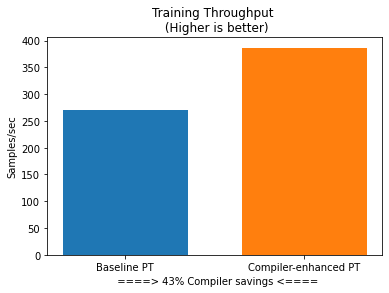

In [52]:
%matplotlib inline

plt.title("Training Throughput \n (Higher is better)")
plt.ylabel("Samples/sec")

plt.bar(x=[1], height=native_throughput, label="Baseline PT", width=0.35)
plt.bar(x=[1.5], height=optimized_throughput, label="Compiler-enhanced PT", width=0.35)

plt.xlabel("  ====> {} Compiler savings <====".format(avg_speedup))
plt.xticks(ticks=[1, 1.5], labels=["Baseline PT", "Compiler-enhanced PT"])

### Convergence of Training Loss

SageMaker Training Compiler does not affect the model convergence behavior. Here, we see the decrease in training loss is similar with and without SageMaker Training Compiler


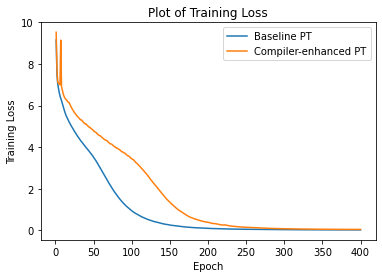

In [53]:
vanilla_loss = [i["loss"] for i in n["train"]]
vanilla_epochs = [i["epoch"] for i in n["train"]]
optimized_loss = [i["loss"] for i in o["train"]]
optimized_epochs = [i["epoch"] for i in o["train"]]

plt.title("Plot of Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.plot(vanilla_epochs, vanilla_loss, label="Baseline PT")
plt.plot(optimized_epochs, optimized_loss, label="Compiler-enhanced PT")
plt.legend()

### Training Stats

Let's compare various training metrics with and without SageMaker Training Compiler. SageMaker Training Compiler provides an increase in training throughput which translates to a decrease in total training time.



In [54]:
pd.DataFrame([n["summary"], o["summary"]], index=["Native", "Compiler-enhanced"])

,train_runtime,train_samples_per_second,train_steps_per_second,train_loss,epoch
Native,2355.3449,270.873,1.698,0.985729,400.0
Compiler-enhanced,1649.8624,386.699,1.212,1.702011,400.0


In [55]:
speedup = (
    (n["summary"]["train_runtime"] - o["summary"]["train_runtime"])
    * 100
    / n["summary"]["train_runtime"]
)
print(
    f"SageMaker Training Compiler is about {int(speedup)}% faster in terms of total training time."
)

SageMaker Training Compiler is about 29% faster in terms of total training time.


### Total Billable Time

Finally, the decrease in total training time results in a decrease in the billable seconds from SageMaker.

In [56]:
def BillableTimeInSeconds(name):
    describe_training_job = (
        optimized_estimator.sagemaker_session.sagemaker_client.describe_training_job
    )
    details = describe_training_job(TrainingJobName=name)
    return details["BillableTimeInSeconds"]

In [57]:
Billable = {}
Billable["Native"] = BillableTimeInSeconds(native_estimator.latest_training_job.name)
Billable["Optimized"] = BillableTimeInSeconds(optimized_estimator.latest_training_job.name)
pd.DataFrame(Billable, index=["BillableSecs"])

,Native,Optimized
BillableSecs,2797,2206


In [58]:
speedup = (Billable["Native"] - Billable["Optimized"]) * 100 / Billable["Native"]
print(f"SageMaker Training Compiler integrated PyTorch was {int(speedup)}% faster in summary.")

SageMaker Training Compiler integrated PyTorch was 21% faster in summary.


## Clean up

Stop all training jobs launched if the jobs are still running.

In [ ]:
import boto3

sm = boto3.client("sagemaker")


def stop_training_job(name):
    status = sm.describe_training_job(TrainingJobName=name)["TrainingJobStatus"]
    if status == "InProgress":
        sm.stop_training_job(TrainingJobName=name)


stop_training_job(native_estimator.latest_training_job.name)
stop_training_job(optimized_estimator.latest_training_job.name)

Also, to find instructions on cleaning up resources, see [Clean Up](https://docs.aws.amazon.com/sagemaker/latest/dg/ex1-cleanup.html) in the *Amazon SageMaker Developer Guide*.